<a href="https://colab.research.google.com/github/tkasod2/TIL/blob/main/prj_analysis/Retailrocket_recommender_system_datase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

data link : https://www.kaggle.com/retailrocket/ecommerce-dataset


## Context
The dataset consists of three files: a file with behaviour data (events.csv), a file with item properties (itemproperties.сsv) and a file, which describes category tree (categorytree.сsv). The data has been collected from a real-world ecommerce website. It is raw data, i.e. without any content transformations, however, all values are hashed due to confidential issues. The purpose of publishing is to motivate researches in the field of recommender systems with implicit feedback.

## Content
The behaviour data, i.e. events like clicks, add to carts, transactions, represent interactions that were collected over a period of 4.5 months. A visitor can make three types of events, namely “view”, “addtocart” or “transaction”. In total there are 2 756 101 events including 2 664 312 views, 69 332 add to carts and 22 457 transactions produced by 1 407 580 unique visitors. For about 90% of events corresponding properties can be found in the “item_properties.csv” file.

For example:

“1439694000000,1,view,100,” means visitorId = 1, clicked the item with id = 100 at 1439694000000 (Unix timestamp)
“1439694000000,2,transaction,1000,234” means visitorId = 2 purchased the item with id = 1000 in transaction with id = 234 at 1439694000000 (Unix timestamp)
The file with item properties (item_properties.csv) includes 20 275 902 rows, i.e. different properties, describing 417 053 unique items. File is divided into 2 files due to file size limitations. Since the property of an item can vary in time (e.g., price changes over time), every row in the file has corresponding timestamp. In other words, the file consists of concatenated snapshots for every week in the file with the behaviour data. However, if a property of an item is constant over the observed period, only a single snapshot value will be present in the file.
For example, we have three properties for single item and 4 weekly snapshots, like below:

Because property=100 is constant over time, property=200 has different values for all snapshots, property=300 has been changed once.

Item properties file contain timestamp column because all of them are time dependent, since properties may change over time, e.g. price, category, etc. Initially, this file consisted of snapshots for every week in the events file and contained over 200 millions rows. We have merged consecutive constant property values, so it's changed from snapshot form to change log form. Thus, constant values would appear only once in the file. This action has significantly reduced the number of rows in 10 times.

All values in the “item_properties.csv” file excluding "categoryid" and "available" properties were hashed. Value of the "categoryid" property contains item category identifier. Value of the "available" property contains availability of the item, i.e. 1 means the item was available, otherwise 0. All numerical values were marked with "n" char at the beginning, and have 3 digits precision after decimal point, e.g., "5" will become "n5.000", "-3.67584" will become "n-3.675". All words in text values were normalized (stemming procedure: https://en.wikipedia.org/wiki/Stemming) and hashed, numbers were processed as above, e.g. text "Hello world 2017!" will become "24214 44214 n2017.000"

The category tree file has 1669 rows. Every row in the file specifies a child categoryId and the corresponding parent.
For example:

Line “100,200” means that categoryid=1 has parent with categoryid=200
Line “300,” means that categoryid hasn’t parent in the tree
## Acknowledgements
Retail Rocket (retailrocket.io) helps web shoppers make better shopping decisions by providing personalized real-time recommendations through multiple channels with over 100MM unique monthly users and 1000+ retail partners over the world.

## Inspiration
How to use item properties and category tree data to improve collaborative filtering model?
Recurrent Neural Networks with Top-k Gains for Session-based Recommendations https://github.com/hidasib/GRU4Rec and paper https://arxiv.org/abs/1706.03847
https://www.researchgate.net/publication/280538158_Application_of_Kullback-Leibler_divergence_for_short-term_user_interest_detection
https://pdfs.semanticscholar.org/66dc/1724c4ed1e74fe6b22e636b52031a33c8ebe.pdf https://www.slideshare.net/LukasLerche/adaptation-and-evaluation-of-recommendationsfor-shortterm-shopping-goals Adaptation and Evaluation of Recommendations for Short-term Shopping Goals
## Tasks
### Task 1
When a customer comes to an e-commerce site, he looks for a product with particular properties: price range, vendor, product type and etc. These properties are implicit, so it's hard to determine them through clicks log.

Try to create an algorithm which predicts properties of items in "addtocart" event by using data from "view" events for any visitor in the published log.

### Task 2
#### Description:
Process of analyzing ecommerce data include very important part of data cleaning. Researchers noticed that in some cases browsing data include up to 40% of abnormal traffic.

Firstly, abnormal users add a lot of noise into data and make recommendation system less effective. In order to increase efficiency of recommendation system, abnormal users should be removed from the raw data.

Secondly, abnormal users add bias to results of split tests, so this type of users should be removed also from split test data.

#### Goals:
The main goal is to find abnormal users of e-shop.

#### Subgoals:
Generate features
Build a model
Create a metric that helps to evaluate quality of the model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# !unzip -qq '/content/drive/MyDrive/공부/Kaggle/eCommerce behavior data from multi category store.zip' -d '/content/drive/MyDrive/공부/Kaggle/eCommerce behavior data from multi category store'

# GPU Check
!nvidia-smi

# # CPU Check
# !head /proc/cpuinfo

# # RAM
# !head -n 3 /proc/meminfo

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Sat Jan 15 10:12:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+------

In [ ]:
import pandas as pd
import os

In [ ]:
# PATH = '/content/drive/MyDrive/공부/Kaggle/Retailrocket recommender system dataset/'

# FILES = list(os.listdir(PATH))
# FILES = [x.split('.csv')[0] for x in FILES]

# def readcsv(x):
#   return pd.read_csv(PATH + x)

# for i in FILES:
#   globals()[f'df_{i}'] = readcsv(i+'.csv') # 전역변수 사용해서, data 읽어오기

In [ ]:
import datetime
def ts_to_dt(df):
  for col in df.columns:
    if col == 'timestamp':
      df['datetime'] = (df['timestamp']/1000).apply(datetime.datetime.fromtimestamp) # timestamp에서 datetime 으로 바꿀때 1000을 나눠줘야한다.
      df['date'] = df['datetime'].dt.strftime('%Y-%m-%d')
    else:
      pass
  return df

In [ ]:
events = ts_to_dt(df_events)

NameError: ignored

In [ ]:
item_pro1 = ts_to_dt(df_item_properties_part1)
item_pro2 = ts_to_dt(df_item_properties_part2)
item_pro2.head()

NameError: ignored

In [ ]:
df_item = pd.concat([item_pro1, item_pro2],ignore_index = True)
df_item.head()

NameError: ignored

In [ ]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 7 columns):
 #   Column         Dtype         
---  ------         -----         
 0   timestamp      int64         
 1   visitorid      int64         
 2   event          object        
 3   itemid         int64         
 4   transactionid  float64       
 5   datetime       datetime64[ns]
 6   date           object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 147.2+ MB


In [ ]:
df_item.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20275902 entries, 0 to 20275901
Data columns (total 6 columns):
 #   Column     Dtype         
---  ------     -----         
 0   timestamp  int64         
 1   itemid     int64         
 2   property   object        
 3   value      object        
 4   datetime   datetime64[ns]
 5   date       object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 928.2+ MB


In [ ]:
# # pickle 저장
# events.to_pickle(PATH+"/df_event.pkl")
# df_item.to_pickle(PATH+"/df_item.pkl")

### ✅Data load < --- 요기부터해도 될듯

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import os
import datetime

!nvidia-smi

Mounted at /content/drive
Sun Jan 16 01:39:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                              

In [2]:
# pickle load
PATH = '/content/drive/MyDrive/공부/Kaggle/Retailrocket recommender system dataset/'
df_event = pd.read_pickle(PATH+"/df_event.pkl")
df_item = pd.read_pickle(PATH+"/df_item.pkl")

### ✅events

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

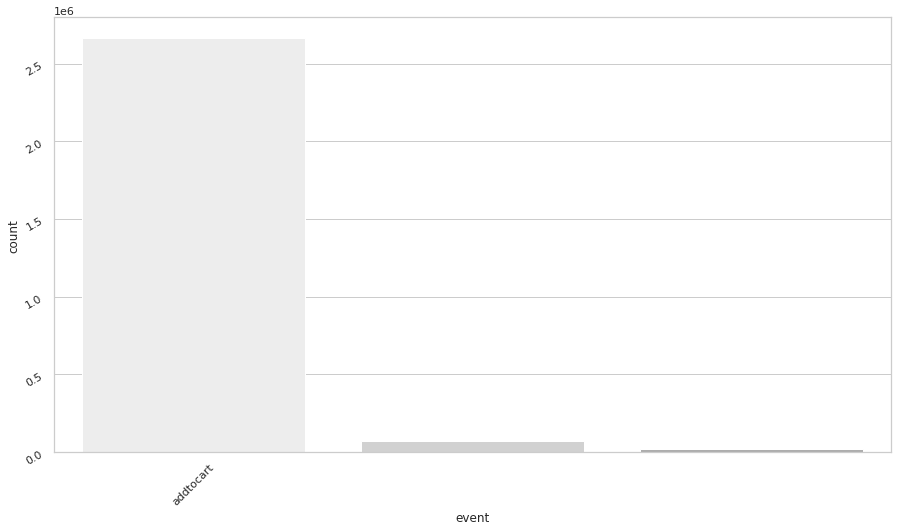

In [4]:
# events['event']
sns.set_theme(style="whitegrid", palette="Greys")
plt.xticks(rotation=45)
plt.yticks(rotation=30) 

g = sns.countplot(x='event',data =df_event)
g.figure.set_size_inches(15, 8)
g.xaxis.set_major_locator(ticker.MultipleLocator(3))


In [5]:
# event and transactionid
# # df['event'].value_counts()
# # # view           2664312
# # # addtocart        69332
# # # transaction      22457


# event가 transaction인 경우에만 transactionid가 존재한다.
df_event.groupby('event')['transactionid'].count().reset_index().rename(columns = {'transaction_id' :'cnt_transaction_id'})


,event,transactionid
0,addtocart,0
1,transaction,22457
2,view,0


In [6]:
df_event.sort_values('timestamp',inplace=True)
df_event.reset_index(drop=True, inplace = True)
df_event.head()

,timestamp,visitorid,event,itemid,transactionid,datetime,date
0,1430622004384,693516,addtocart,297662,NaN,2015-05-03 03:00:04.384,2015-05-03
1,1430622011289,829044,view,60987,NaN,2015-05-03 03:00:11.289,2015-05-03
2,1430622013048,652699,view,252860,NaN,2015-05-03 03:00:13.048,2015-05-03
3,1430622024154,1125936,view,33661,NaN,2015-05-03 03:00:24.154,2015-05-03
4,1430622026228,693516,view,297662,NaN,2015-05-03 03:00:26.228,2015-05-03


In [7]:
df_event.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 7 columns):
 #   Column         Dtype         
---  ------         -----         
 0   timestamp      int64         
 1   visitorid      int64         
 2   event          object        
 3   itemid         int64         
 4   transactionid  float64       
 5   datetime       datetime64[ns]
 6   date           object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 147.2+ MB


#### DAU, MAU, WAU, Engagement 혹은 Stickiness(DAU/MAU)
- 우선 기본적인 대시보드를 만들어보자

In [8]:
df_event['month'] = df_event['datetime'].dt.strftime('%Y-%m')
df_event['week'] = df_event['datetime'].dt.strftime('%Y-w%U')
df_event.head()

,timestamp,visitorid,event,itemid,transactionid,datetime,date,month,week
0,1430622004384,693516,addtocart,297662,NaN,2015-05-03 03:00:04.384,2015-05-03,2015-05,2015-w18
1,1430622011289,829044,view,60987,NaN,2015-05-03 03:00:11.289,2015-05-03,2015-05,2015-w18
2,1430622013048,652699,view,252860,NaN,2015-05-03 03:00:13.048,2015-05-03,2015-05,2015-w18
3,1430622024154,1125936,view,33661,NaN,2015-05-03 03:00:24.154,2015-05-03,2015-05,2015-w18
4,1430622026228,693516,view,297662,NaN,2015-05-03 03:00:26.228,2015-05-03,2015-05,2015-w18


In [9]:
DAU = df_event.groupby('date')['visitorid'].count().reset_index().rename(columns = {'visitorid':'cnt_visit'})
DAU.head()

,date,cnt_visit
0,2015-05-03,13683
1,2015-05-04,19414
2,2015-05-05,23015
3,2015-05-06,23920
4,2015-05-07,23164


In [10]:
DAU['date'] = pd.to_datetime(DAU['date'])
DAU['cnt_visit'] = DAU['cnt_visit'].astype('int32')

In [11]:
DAU

,date,cnt_visit
0,2015-05-03,13683
1,2015-05-04,19414
2,2015-05-05,23015
3,2015-05-06,23920
4,2015-05-07,23164
...,...,...
134,2015-09-14,20913
135,2015-09-15,20427
136,2015-09-16,11495
137,2015-09-17,10128


Text(0, 0.5, 'User_cnt')

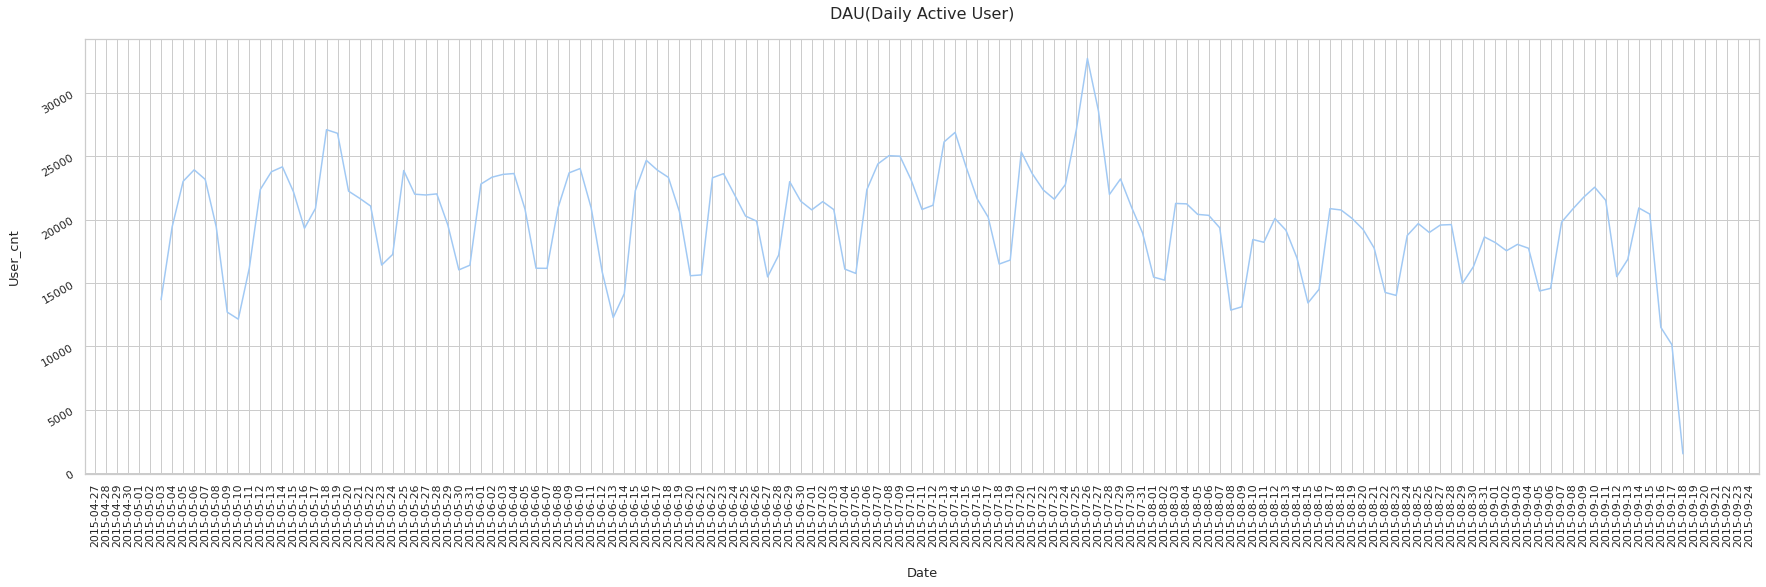

In [13]:
sns.set_theme(style="whitegrid", palette="pastel")
plt.xticks(rotation=90)
plt.yticks(rotation=30) 

g = sns.lineplot(x='date', y='cnt_visit',data =DAU)
g.figure.set_size_inches(30, 8)
g.xaxis.set_major_locator(ticker.MultipleLocator(1))

g.set_title("DAU(Daily Active User)", pad=20, size=16)
g.set_xlabel("Date",labelpad = 20, size = 13)
g.set_ylabel("User_cnt",labelpad = 20, size = 13)

Text(0, 0.5, 'User_cnt')

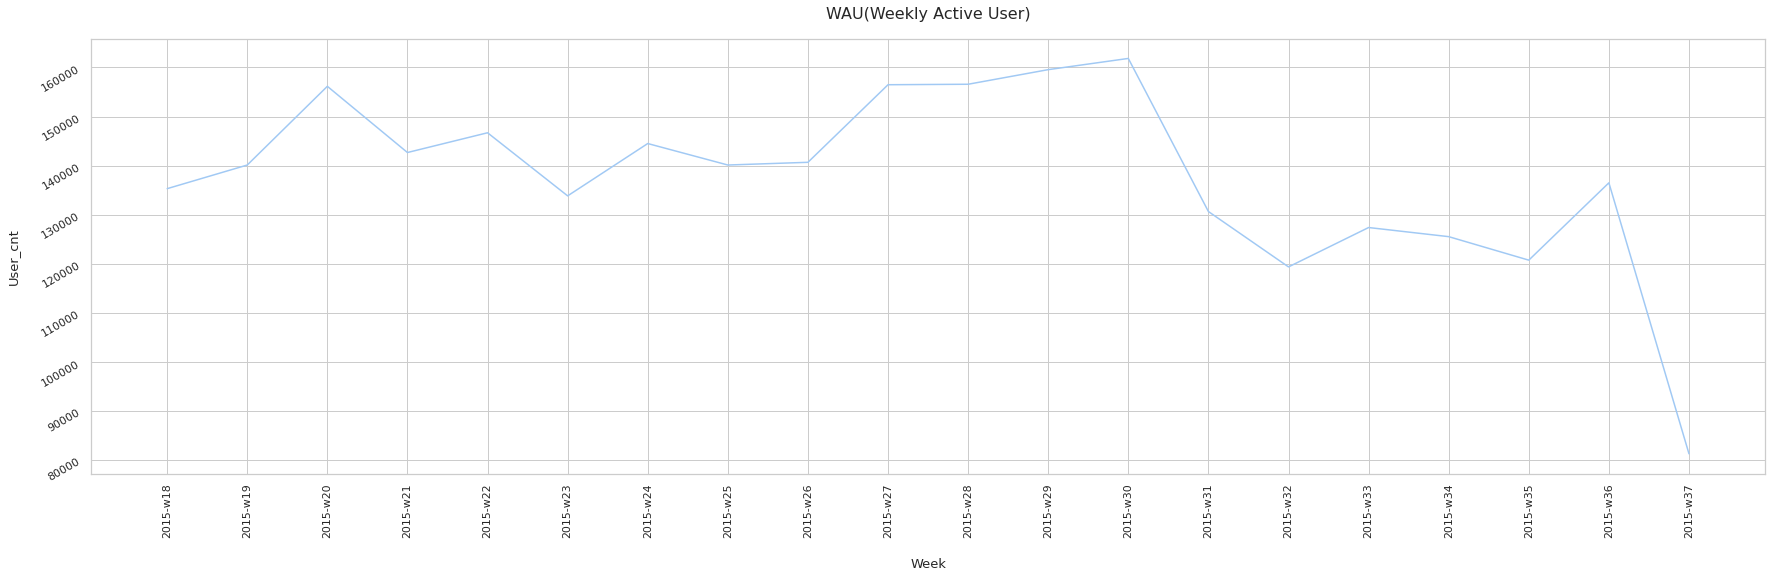

In [14]:
# WAU
WAU = df_event.groupby('week')['visitorid'].count().reset_index().rename(columns = {'visitorid':'cnt_visit'})

sns.set_theme(style="whitegrid", palette="pastel")
plt.xticks(rotation=90)
plt.yticks(rotation=30) 

g = sns.lineplot(x='week', y='cnt_visit',data =WAU)
g.figure.set_size_inches(30, 8)
g.xaxis.set_major_locator(ticker.MultipleLocator(1))

g.set_title("WAU(Weekly Active User)", pad=20, size=16)
g.set_xlabel("Week",labelpad = 20, size = 13)
g.set_ylabel("User_cnt",labelpad = 20, size = 13)

Text(0, 0.5, 'User_cnt')

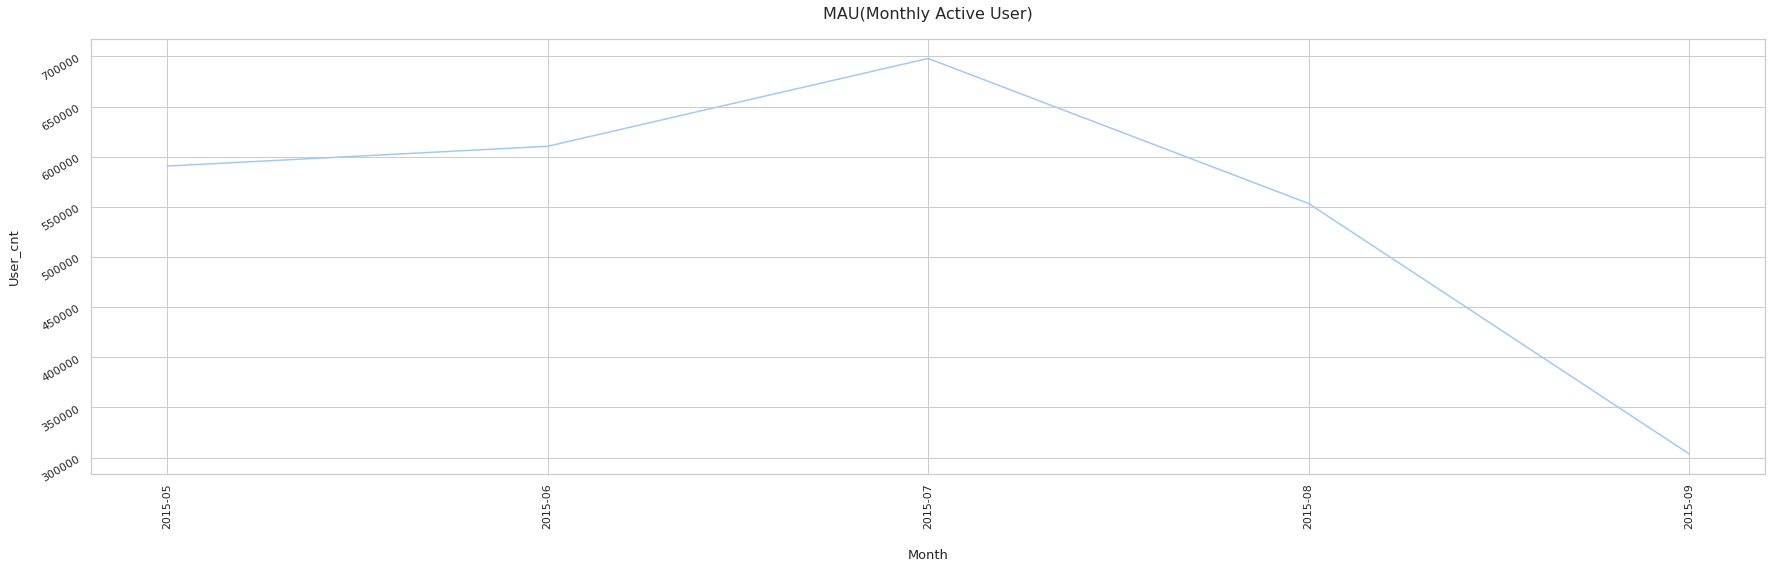

In [15]:
# MAU
MAU = df_event.groupby('month')['visitorid'].count().reset_index().rename(columns = {'visitorid':'cnt_visit'})

sns.set_theme(style="whitegrid", palette="pastel")
plt.xticks(rotation=90)
plt.yticks(rotation=30) 

g = sns.lineplot(x='month', y='cnt_visit',data =MAU)
g.figure.set_size_inches(30, 8)
g.xaxis.set_major_locator(ticker.MultipleLocator(1))

g.set_title("MAU(Monthly Active User)", pad=20, size=16)
g.set_xlabel("Month",labelpad = 20, size = 13)
g.set_ylabel("User_cnt",labelpad = 20, size = 13)

In [16]:
# dau/mau
print('DAU : ',DAU['cnt_visit'].mean())
print('MAU : ',MAU['cnt_visit'].mean())
print('DAU/MAU : ',DAU['cnt_visit'].mean()/MAU['cnt_visit'].mean() )

# dau/mau가 거의 1/30에 가깝다. 즉, 고객의 재방문율이 떨어진다.
# 하지만, 데이터의 맹점이 있다. 9월 MAU가 상당히 떨어지는 이유는, 9월 17일까지의 데이터까지 온전하기 때문이다.
# 따라서, 9월의 Data를 아예 지우든, 혹은 대체값을 만들든(ex. 9월MAU * 30/17) 해서 수행하는것이 올바르다.


DAU :  19828.06474820144
MAU :  551220.2
DAU/MAU :  0.03597122302158274


In [17]:
# stickiness 월별 시각화
STICKINESS = df_event.groupby('date')['visitorid'].count().reset_index().rename(columns = {'visitorid':'cnt_visit'})
STICKINESS['date']=pd.to_datetime(STICKINESS['date'])
STICKINESS['month'] = STICKINESS['date'].dt.strftime('%Y-%m')
STICKINESS = STICKINESS.merge(MAU, on='month')
STICKINESS['sticky'] = STICKINESS['cnt_visit_x']/STICKINESS['cnt_visit_y']
STICKY = STICKINESS.groupby('month')['sticky'].mean().reset_index().rename(columns = {'sticky':'avg_sticky'})
STICKY

,month,avg_sticky
0,2015-05,0.034483
1,2015-06,0.033333
2,2015-07,0.032258
3,2015-08,0.032258
4,2015-09,0.055556


Text(0.5, 1.0, 'Stickiness')

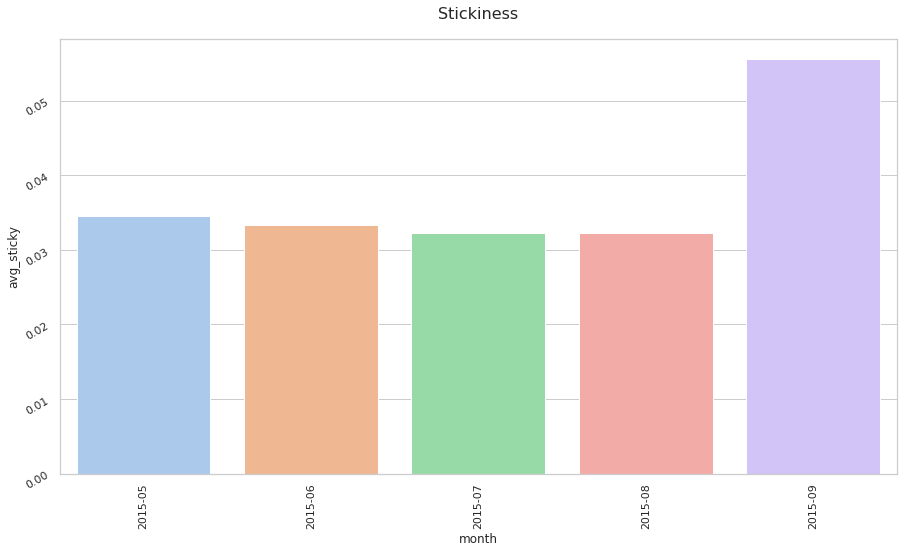

In [18]:
sns.set_theme(style = 'whitegrid', palette = 'pastel')
plt.xticks(rotation=90)
plt.yticks(rotation=30)

g = sns.barplot(x='month', y='avg_sticky',data = STICKY)
g.figure.set_size_inches(15, 8)
# g.xaxis.set_major_locator(ticker.MultipleLocator(0))
g.set_title("Stickiness", pad=20, size=16)

과연, 9월의 Stickiness가 커진 이유가 뭘까?  
-> 데이터 부족으로 인해, MAU가 큰 이유다.

다만, 만약에 실제 데이터상으로 유의미한 차이가 있다라면, 하락세던 Stickiness가 왜 떨어졌는지 생각해보자  
-> 
예상1) MAU 대비 DAU 비중이 높다는것은, 신규고객이 많다라는 뜻이 될 수 있다.
하지만, 맞아도 문제다. 9월 DAU가 낮은데, 경쟁사라든지 어떤 출현으로 시장 점유를 빼앗겨서 진행한 마케팅 액션으로 겨우겨우 살아가는건 아닐지 생각해봐야한다.

예상2) 


#### Cohort 분석

In [19]:
## 첫 방문 데이터, visitorid 기준
first_come_date = df_event[['visitorid','date']].drop_duplicates(subset = 'visitorid', keep = 'first')
first_come_date.reset_index(drop = True,inplace=True)
first_come_date = first_come_date.rename(columns ={'date':'first_date'})
first_come_date

## 275만개 data -> 140만개 data

,visitorid,first_date
0,693516,2015-05-03
1,829044,2015-05-03
2,652699,2015-05-03
3,1125936,2015-05-03
4,1149227,2015-05-03
...,...,...
1407575,998517,2015-09-18
1407576,472345,2015-09-18
1407577,1207677,2015-09-18
1407578,255126,2015-09-18


In [20]:
cohort = df_event.merge(first_come_date, how = 'left',on = 'visitorid')

## data type 변경
# cohort['date'] = cohort['date'].map(pd.to_datetime) -- map 함수는 너무 오래걸려서 skip
cohort['first_date']= pd.to_datetime(cohort['first_date'])
cohort['date']= pd.to_datetime(cohort['date'])
cohort['first_month'] = cohort['first_date'].dt.to_period('M')

# term col 추가
cohort['term'] = cohort['date'] - cohort['first_date']
cohort.head()

,timestamp,visitorid,event,itemid,transactionid,datetime,date,month,week,first_date,first_month,term
0,1430622004384,693516,addtocart,297662,NaN,2015-05-03 03:00:04.384,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days
1,1430622011289,829044,view,60987,NaN,2015-05-03 03:00:11.289,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days
2,1430622013048,652699,view,252860,NaN,2015-05-03 03:00:13.048,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days
3,1430622024154,1125936,view,33661,NaN,2015-05-03 03:00:24.154,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days
4,1430622026228,693516,view,297662,NaN,2015-05-03 03:00:26.228,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days


In [21]:
# 2회 이상 transaction이 된 경우 확인
cohort.loc[(cohort['event'] == 'transaction','visitorid')].value_counts()
# cohort[~(cohort['transactionid'].isna())].groupby('visitorid')['visitorid'].count()
# max 559회

# cohort[~(cohort['transactionid'].isna())].groupby('visitorid')['visitorid'].count().mean()
# # 평균 1.9162897858179027회

1150086    559
152963     349
530559     286
684514     189
861299     188
          ... 
356340       1
835566       1
266350       1
1083369      1
1300499      1
Name: visitorid, Length: 11719, dtype: int64

In [22]:
# transaction 발생 시, 몇번째 transaction인지 체크
cohort['transaction_cnt'] = 0 # 0으로 초기화

# 고객 별 transaction 횟수
# time 기준으로 정렬되어있으므로, rank 함수로 처리함
cohort.loc[(~cohort['transactionid'].isna(), 'transaction_cnt')] =\
cohort[~cohort['transactionid'].isna()].groupby('visitorid')['transaction_cnt'].rank(method = 'first') # -------- ★ 


In [23]:
# last visit
cohort['last_visit'] = cohort.groupby('visitorid')['date'].shift(1)

# cohort['last_visit']= cohort['last_visit'].fillna(cohort['date'])
cohort

,timestamp,visitorid,event,itemid,transactionid,datetime,date,month,week,first_date,first_month,term,transaction_cnt,last_visit
0,1430622004384,693516,addtocart,297662,NaN,2015-05-03 03:00:04.384,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,NaT
1,1430622011289,829044,view,60987,NaN,2015-05-03 03:00:11.289,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,NaT
2,1430622013048,652699,view,252860,NaN,2015-05-03 03:00:13.048,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,NaT
3,1430622024154,1125936,view,33661,NaN,2015-05-03 03:00:24.154,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,NaT
4,1430622026228,693516,view,297662,NaN,2015-05-03 03:00:26.228,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,2015-05-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2756096,1442545164029,472345,view,301436,NaN,2015-09-18 02:59:24.029,2015-09-18,2015-09,2015-w37,2015-09-18,2015-09,0 days,0.0,NaT
2756097,1442545165499,1207677,view,310922,NaN,2015-09-18 02:59:25.499,2015-09-18,2015-09,2015-w37,2015-09-18,2015-09,0 days,0.0,NaT
2756098,1442545174109,255126,view,47467,NaN,2015-09-18 02:59:34.109,2015-09-18,2015-09,2015-w37,2015-09-18,2015-09,0 days,0.0,NaT
2756099,1442545181778,622226,view,345308,NaN,2015-09-18 02:59:41.778,2015-09-18,2015-09,2015-w37,2015-09-18,2015-09,0 days,0.0,NaT


In [24]:
cohort['term_month'] = cohort['term'].dt.days # timedelta -> int로 변경
cohort['term_month'] = cohort['term_month']//30
cohort['term_month']

0          0
1          0
2          0
3          0
4          0
          ..
2756096    0
2756097    0
2756098    0
2756099    0
2756100    0
Name: term_month, Length: 2756101, dtype: int64

In [25]:
cohort[~cohort['transactionid'].isna()].reset_index(drop=True)

,timestamp,visitorid,event,itemid,transactionid,datetime,date,month,week,first_date,first_month,term,transaction_cnt,last_visit,term_month
0,1430623641391,869008,transaction,40685,9765.0,2015-05-03 03:27:21.391,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,1.0,2015-05-03,0
1,1430624101772,345781,transaction,438400,1016.0,2015-05-03 03:35:01.772,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,1.0,2015-05-03,0
2,1430625707591,586756,transaction,440917,10942.0,2015-05-03 04:01:47.591,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,1.0,2015-05-03,0
3,1430626058961,435495,transaction,175893,6173.0,2015-05-03 04:07:38.961,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,1.0,2015-05-03,0
4,1430627474903,266417,transaction,445106,12546.0,2015-05-03 04:31:14.903,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,1.0,2015-05-03,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22452,1442542096512,152963,transaction,12504,5772.0,2015-09-18 02:08:16.512,2015-09-18,2015-09,2015-w37,2015-07-31,2015-07,49 days,345.0,2015-09-18,1
22453,1442542096512,152963,transaction,72462,5772.0,2015-09-18 02:08:16.512,2015-09-18,2015-09,2015-w37,2015-07-31,2015-07,49 days,346.0,2015-09-18,1
22454,1442542096528,152963,transaction,380196,5772.0,2015-09-18 02:08:16.528,2015-09-18,2015-09,2015-w37,2015-07-31,2015-07,49 days,347.0,2015-09-18,1
22455,1442543898098,152963,transaction,362697,5670.0,2015-09-18 02:38:18.098,2015-09-18,2015-09,2015-w37,2015-07-31,2015-07,49 days,348.0,2015-09-18,1


In [26]:
df_cohort = cohort[~cohort['transactionid'].isna()].reset_index(drop=True)
cohort_vis = df_cohort[['first_month','term_month','visitorid']].drop_duplicates().reset_index(drop = True).groupby(['first_month','term_month']).count().rename(columns ={'visitorid':'count_visit'})
cohort_vis = cohort_vis.unstack()
cohort_vis.columns = cohort_vis.columns.droplevel(0) # multi-index 제거
cohort_vis = cohort_vis.divide(cohort_vis[0],axis=0) # 첫달껄로 다 나눠주기
cohort_vis

term_month,0,1,2,3,4
first_month,,,,,
2015-05,1.0,0.069455,0.050037,0.032114,0.007095
2015-06,1.0,0.038073,0.025641,0.006605,NaN
2015-07,1.0,0.033110,0.004092,NaN,NaN
2015-08,1.0,0.008559,NaN,NaN,NaN
2015-09,1.0,NaN,NaN,NaN,NaN


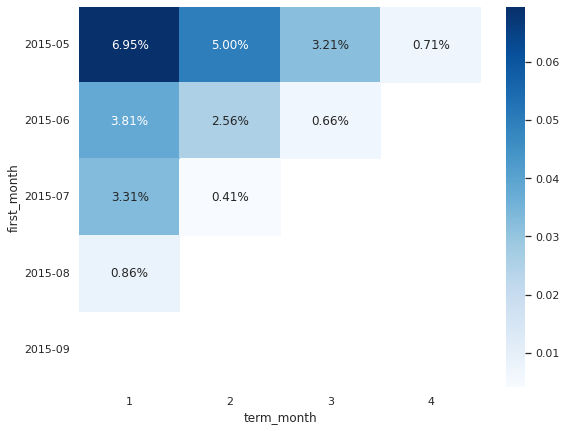

In [27]:
sns.set_theme(style="whitegrid", palette="pastel")
g = sns.heatmap(cohort_vis.iloc[:,1:], annot=True, fmt='.2%', cmap="Blues")
g.figure.set_size_inches(9, 7) 

### 군집분석

In [28]:
cohort.head()

,timestamp,visitorid,event,itemid,transactionid,datetime,date,month,week,first_date,first_month,term,transaction_cnt,last_visit,term_month
0,1430622004384,693516,addtocart,297662,NaN,2015-05-03 03:00:04.384,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,NaT,0
1,1430622011289,829044,view,60987,NaN,2015-05-03 03:00:11.289,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,NaT,0
2,1430622013048,652699,view,252860,NaN,2015-05-03 03:00:13.048,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,NaT,0
3,1430622024154,1125936,view,33661,NaN,2015-05-03 03:00:24.154,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,NaT,0
4,1430622026228,693516,view,297662,NaN,2015-05-03 03:00:26.228,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,2015-05-03,0


In [29]:
pd.get_dummies(cohort['event'],prefix = 'event')

,event_addtocart,event_transaction,event_view
0,1,0,0
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
2756096,0,0,1
2756097,0,0,1
2756098,0,0,1
2756099,0,0,1


In [30]:
df_clustering_temp = pd.concat([cohort, pd.get_dummies(cohort['event'],prefix = 'event')], axis=1)
df_clustering_temp

,timestamp,visitorid,event,itemid,transactionid,datetime,date,month,week,first_date,first_month,term,transaction_cnt,last_visit,term_month,event_addtocart,event_transaction,event_view
0,1430622004384,693516,addtocart,297662,NaN,2015-05-03 03:00:04.384,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,NaT,0,1,0,0
1,1430622011289,829044,view,60987,NaN,2015-05-03 03:00:11.289,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,NaT,0,0,0,1
2,1430622013048,652699,view,252860,NaN,2015-05-03 03:00:13.048,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,NaT,0,0,0,1
3,1430622024154,1125936,view,33661,NaN,2015-05-03 03:00:24.154,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,NaT,0,0,0,1
4,1430622026228,693516,view,297662,NaN,2015-05-03 03:00:26.228,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,2015-05-03,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2756096,1442545164029,472345,view,301436,NaN,2015-09-18 02:59:24.029,2015-09-18,2015-09,2015-w37,2015-09-18,2015-09,0 days,0.0,NaT,0,0,0,1
2756097,1442545165499,1207677,view,310922,NaN,2015-09-18 02:59:25.499,2015-09-18,2015-09,2015-w37,2015-09-18,2015-09,0 days,0.0,NaT,0,0,0,1
2756098,1442545174109,255126,view,47467,NaN,2015-09-18 02:59:34.109,2015-09-18,2015-09,2015-w37,2015-09-18,2015-09,0 days,0.0,NaT,0,0,0,1
2756099,1442545181778,622226,view,345308,NaN,2015-09-18 02:59:41.778,2015-09-18,2015-09,2015-w37,2015-09-18,2015-09,0 days,0.0,NaT,0,0,0,1


In [31]:
total = df_clustering_temp.groupby('visitorid')[[x for x in df_clustering_temp.columns[-3:]]].agg(sum)
total.columns = ['total_addtocart', 'total_transaction','total_view']
total

,total_addtocart,total_transaction,total_view
visitorid,,,
0,0.0,0.0,3.0
1,0.0,0.0,1.0
2,0.0,0.0,8.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0
...,...,...,...
1407575,0.0,0.0,1.0
1407576,0.0,0.0,1.0
1407577,0.0,0.0,1.0


In [32]:
df_clustering = df_clustering_temp.merge(total,how='left',on='visitorid')
df_clustering.head()

,timestamp,visitorid,event,itemid,transactionid,datetime,date,month,week,first_date,first_month,term,transaction_cnt,last_visit,term_month,event_addtocart,event_transaction,event_view,total_addtocart,total_transaction,total_view
0,1430622004384,693516,addtocart,297662,NaN,2015-05-03 03:00:04.384,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,NaT,0,1,0,0,2.0,0.0,1.0
1,1430622011289,829044,view,60987,NaN,2015-05-03 03:00:11.289,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,NaT,0,0,0,1,0.0,0.0,1.0
2,1430622013048,652699,view,252860,NaN,2015-05-03 03:00:13.048,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,NaT,0,0,0,1,0.0,0.0,1.0
3,1430622024154,1125936,view,33661,NaN,2015-05-03 03:00:24.154,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,NaT,0,0,0,1,0.0,0.0,1.0
4,1430622026228,693516,view,297662,NaN,2015-05-03 03:00:26.228,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,2015-05-03,0,0,0,1,2.0,0.0,1.0


In [33]:
df_clustering['total_event'] = df_clustering['total_addtocart'] + df_clustering['total_addtocart'] + df_clustering['total_addtocart']
df_clustering

,timestamp,visitorid,event,itemid,transactionid,datetime,date,month,week,first_date,first_month,term,transaction_cnt,last_visit,term_month,event_addtocart,event_transaction,event_view,total_addtocart,total_transaction,total_view,total_event
0,1430622004384,693516,addtocart,297662,NaN,2015-05-03 03:00:04.384,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,NaT,0,1,0,0,2.0,0.0,1.0,6.0
1,1430622011289,829044,view,60987,NaN,2015-05-03 03:00:11.289,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,NaT,0,0,0,1,0.0,0.0,1.0,0.0
2,1430622013048,652699,view,252860,NaN,2015-05-03 03:00:13.048,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,NaT,0,0,0,1,0.0,0.0,1.0,0.0
3,1430622024154,1125936,view,33661,NaN,2015-05-03 03:00:24.154,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,NaT,0,0,0,1,0.0,0.0,1.0,0.0
4,1430622026228,693516,view,297662,NaN,2015-05-03 03:00:26.228,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,2015-05-03,0,0,0,1,2.0,0.0,1.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2756096,1442545164029,472345,view,301436,NaN,2015-09-18 02:59:24.029,2015-09-18,2015-09,2015-w37,2015-09-18,2015-09,0 days,0.0,NaT,0,0,0,1,0.0,0.0,1.0,0.0
2756097,1442545165499,1207677,view,310922,NaN,2015-09-18 02:59:25.499,2015-09-18,2015-09,2015-w37,2015-09-18,2015-09,0 days,0.0,NaT,0,0,0,1,0.0,0.0,1.0,0.0
2756098,1442545174109,255126,view,47467,NaN,2015-09-18 02:59:34.109,2015-09-18,2015-09,2015-w37,2015-09-18,2015-09,0 days,0.0,NaT,0,0,0,1,0.0,0.0,1.0,0.0
2756099,1442545181778,622226,view,345308,NaN,2015-09-18 02:59:41.778,2015-09-18,2015-09,2015-w37,2015-09-18,2015-09,0 days,0.0,NaT,0,0,0,1,0.0,0.0,1.0,0.0


In [34]:
# df_clustering['first_month'].astype(int)

In [35]:
df_clustering = pd.concat([df_clustering, pd.get_dummies(df_clustering['first_month'])],axis=1)
df_clustering

,timestamp,visitorid,event,itemid,transactionid,datetime,date,month,week,first_date,first_month,term,transaction_cnt,last_visit,term_month,event_addtocart,event_transaction,event_view,total_addtocart,total_transaction,total_view,total_event,2015-05,2015-06,2015-07,2015-08,2015-09
0,1430622004384,693516,addtocart,297662,NaN,2015-05-03 03:00:04.384,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,NaT,0,1,0,0,2.0,0.0,1.0,6.0,1,0,0,0,0
1,1430622011289,829044,view,60987,NaN,2015-05-03 03:00:11.289,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,NaT,0,0,0,1,0.0,0.0,1.0,0.0,1,0,0,0,0
2,1430622013048,652699,view,252860,NaN,2015-05-03 03:00:13.048,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,NaT,0,0,0,1,0.0,0.0,1.0,0.0,1,0,0,0,0
3,1430622024154,1125936,view,33661,NaN,2015-05-03 03:00:24.154,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,NaT,0,0,0,1,0.0,0.0,1.0,0.0,1,0,0,0,0
4,1430622026228,693516,view,297662,NaN,2015-05-03 03:00:26.228,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,2015-05-03,0,0,0,1,2.0,0.0,1.0,6.0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2756096,1442545164029,472345,view,301436,NaN,2015-09-18 02:59:24.029,2015-09-18,2015-09,2015-w37,2015-09-18,2015-09,0 days,0.0,NaT,0,0,0,1,0.0,0.0,1.0,0.0,0,0,0,0,1
2756097,1442545165499,1207677,view,310922,NaN,2015-09-18 02:59:25.499,2015-09-18,2015-09,2015-w37,2015-09-18,2015-09,0 days,0.0,NaT,0,0,0,1,0.0,0.0,1.0,0.0,0,0,0,0,1
2756098,1442545174109,255126,view,47467,NaN,2015-09-18 02:59:34.109,2015-09-18,2015-09,2015-w37,2015-09-18,2015-09,0 days,0.0,NaT,0,0,0,1,0.0,0.0,1.0,0.0,0,0,0,0,1
2756099,1442545181778,622226,view,345308,NaN,2015-09-18 02:59:41.778,2015-09-18,2015-09,2015-w37,2015-09-18,2015-09,0 days,0.0,NaT,0,0,0,1,0.0,0.0,1.0,0.0,0,0,0,0,1


In [36]:
cluster_col = [x for x in df_clustering.columns[-8:]]

In [37]:
df_cluster= df_clustering[cluster_col]
df_cluster

,total_transaction,total_view,total_event,2015-05,2015-06,2015-07,2015-08,2015-09
0,0.0,1.0,6.0,1,0,0,0,0
1,0.0,1.0,0.0,1,0,0,0,0
2,0.0,1.0,0.0,1,0,0,0,0
3,0.0,1.0,0.0,1,0,0,0,0
4,0.0,1.0,6.0,1,0,0,0,0
...,...,...,...,...,...,...,...,...
2756096,0.0,1.0,0.0,0,0,0,0,1
2756097,0.0,1.0,0.0,0,0,0,0,1
2756098,0.0,1.0,0.0,0,0,0,0,1
2756099,0.0,1.0,0.0,0,0,0,0,1


In [38]:
df_cluster.columns = ['total_transaction','total_view','total_event','5','6','7','8','9']

memory 문제로 일단 5%만 돌려보자

In [50]:
df_for_cluster = df_cluster.sample(frac=0.01, random_state=0).reset_index(drop=True)
df_for_cluster

,total_transaction,total_view,total_event,5,6,7,8,9
0,0.0,1.0,0.0,1,0,0,0,0
1,0.0,1.0,0.0,0,0,0,0,1
2,0.0,2.0,0.0,0,0,1,0,0
3,0.0,11.0,0.0,1,0,0,0,0
4,0.0,8.0,0.0,0,0,1,0,0
...,...,...,...,...,...,...,...,...
27556,0.0,2.0,0.0,0,0,0,1,0
27557,0.0,1.0,0.0,1,0,0,0,0
27558,0.0,1.0,0.0,0,1,0,0,0
27559,0.0,1.0,0.0,0,0,0,1,0


In [40]:
from sklearn.cluster import KMeans
import sklearn.preprocessing

In [61]:
from sklearn.preprocessing import StandardScaler
stdscaler = StandardScaler()
df_for_cluster.iloc[:,:] = stdscaler.fit_transform(df_for_cluster)
df_for_cluster

,total_transaction,total_view,total_event,5,6,7,8,9
0,-0.123381,-0.164195,-0.132167,1.687828,-0.539084,-0.565381,-0.467197,-0.321370
1,-0.123381,-0.164195,-0.132167,-0.592477,-0.539084,-0.565381,-0.467197,3.111681
2,-0.123381,-0.161831,-0.132167,-0.592477,-0.539084,1.768720,-0.467197,-0.321370
3,-0.123381,-0.140550,-0.132167,1.687828,-0.539084,-0.565381,-0.467197,-0.321370
4,-0.123381,-0.147644,-0.132167,-0.592477,-0.539084,1.768720,-0.467197,-0.321370
...,...,...,...,...,...,...,...,...
27556,-0.123381,-0.161831,-0.132167,-0.592477,-0.539084,-0.565381,2.140423,-0.321370
27557,-0.123381,-0.164195,-0.132167,1.687828,-0.539084,-0.565381,-0.467197,-0.321370
27558,-0.123381,-0.164195,-0.132167,-0.592477,1.855000,-0.565381,-0.467197,-0.321370
27559,-0.123381,-0.164195,-0.132167,-0.592477,-0.539084,-0.565381,2.140423,-0.321370


In [62]:
## elbow check
K = range(1,10)

distortions = []
for k in K:
    kmeans_cls = KMeans(n_clusters=k)
    kmeans_cls.fit(df_for_cluster)
    distortions.append(kmeans_cls.inertia_) # within-cluster sum-of-squares criterion

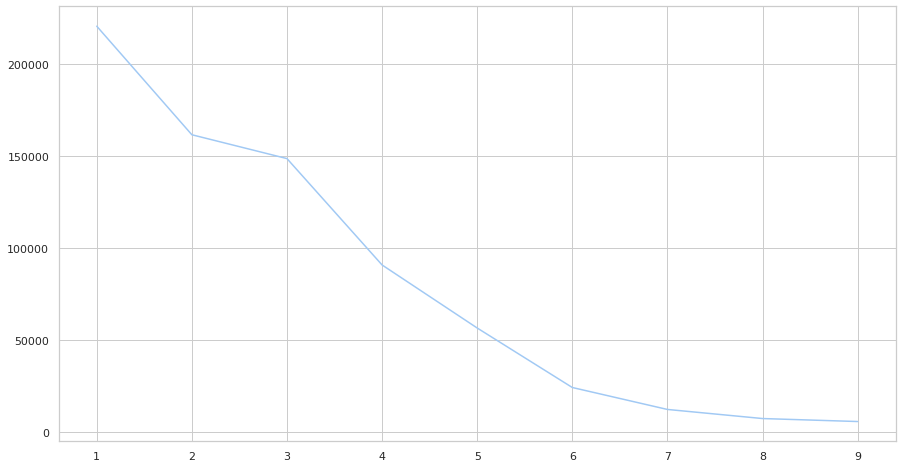

In [63]:
g = sns.lineplot(x=K, y= distortions, markers= False, dashes=True)
g.figure.set_size_inches(15, 8) 

## 6개 군집정도로 자르면 될듯하다.

In [68]:
#Hierarchical Clustering  #RAM이 터지네..
from sklearn.cluster import AgglomerativeClustering
AC = AgglomerativeClustering(n_clusters=6,affinity='euclidean')
pred_AC = AC.fit_predict(df_for_cluster)


In [70]:
df_for_cluster['class'].value_counts()

0    7450
3    6500
4    5994
2    4894
5    2573
1     150
Name: class, dtype: int64

In [69]:
df_for_cluster['class'] = pred_AC
df_for_cluster

,total_transaction,total_view,total_event,5,6,7,8,9,class
0,-0.123381,-0.164195,-0.132167,1.687828,-0.539084,-0.565381,-0.467197,-0.321370,0
1,-0.123381,-0.164195,-0.132167,-0.592477,-0.539084,-0.565381,-0.467197,3.111681,5
2,-0.123381,-0.161831,-0.132167,-0.592477,-0.539084,1.768720,-0.467197,-0.321370,3
3,-0.123381,-0.140550,-0.132167,1.687828,-0.539084,-0.565381,-0.467197,-0.321370,0
4,-0.123381,-0.147644,-0.132167,-0.592477,-0.539084,1.768720,-0.467197,-0.321370,3
...,...,...,...,...,...,...,...,...,...
27556,-0.123381,-0.161831,-0.132167,-0.592477,-0.539084,-0.565381,2.140423,-0.321370,2
27557,-0.123381,-0.164195,-0.132167,1.687828,-0.539084,-0.565381,-0.467197,-0.321370,0
27558,-0.123381,-0.164195,-0.132167,-0.592477,1.855000,-0.565381,-0.467197,-0.321370,4
27559,-0.123381,-0.164195,-0.132167,-0.592477,-0.539084,-0.565381,2.140423,-0.321370,2


In [71]:
silhouette_samples?

In [81]:
df_for_cluster['total_transaction'].to_numpy()

array([-0.12338086, -0.12338086, -0.12338086, ..., -0.12338086,
       -0.12338086, -0.12338086])

In [83]:
from sklearn.metrics import silhouette_samples

# Hierachical
sample_silhouette_values = silhouette_samples(df_for_cluster['total_transaction'].to_numpy().reshape(-1,1), pred_AC)

In [85]:
df_for_cluster['silhouette_coefficient'] = sample_silhouette_values
df_for_cluster

,total_transaction,total_view,total_event,5,6,7,8,9,class,silhouette_coefficient
0,-0.123381,-0.164195,-0.132167,1.687828,-0.539084,-0.565381,-0.467197,-0.321370,0,-0.984942
1,-0.123381,-0.164195,-0.132167,-0.592477,-0.539084,-0.565381,-0.467197,3.111681,5,0.672557
2,-0.123381,-0.161831,-0.132167,-0.592477,-0.539084,1.768720,-0.467197,-0.321370,3,-0.672735
3,-0.123381,-0.140550,-0.132167,1.687828,-0.539084,-0.565381,-0.467197,-0.321370,0,-0.984942
4,-0.123381,-0.147644,-0.132167,-0.592477,-0.539084,1.768720,-0.467197,-0.321370,3,-0.672735
...,...,...,...,...,...,...,...,...,...,...
27556,-0.123381,-0.161831,-0.132167,-0.592477,-0.539084,-0.565381,2.140423,-0.321370,2,-0.673016
27557,-0.123381,-0.164195,-0.132167,1.687828,-0.539084,-0.565381,-0.467197,-0.321370,0,-0.984942
27558,-0.123381,-0.164195,-0.132167,-0.592477,1.855000,-0.565381,-0.467197,-0.321370,4,-0.707753
27559,-0.123381,-0.164195,-0.132167,-0.592477,-0.539084,-0.565381,2.140423,-0.321370,2,-0.673016


In [87]:
print("Hierachical",sample_silhouette_values.mean())

Hierachical -0.588903171927142


#### ✅df_item

In [ ]:
df_item.sort_values('timestamp',inplace=True)
df_item.reset_index(drop=True, inplace = True)
df_item.head()

,timestamp,itemid,property,value,datetime,date
0,1431226800000,317951,790,n32880.000,2015-05-10 03:00:00,2015-05-10
1,1431226800000,422842,480,1133979,2015-05-10 03:00:00,2015-05-10
2,1431226800000,310185,776,103591,2015-05-10 03:00:00,2015-05-10
3,1431226800000,110973,112,679677,2015-05-10 03:00:00,2015-05-10
4,1431226800000,179597,available,0,2015-05-10 03:00:00,2015-05-10


In [ ]:
df_item[df_item['itemid']==243157]

,timestamp,itemid,property,value,datetime,date
19387056,1441508400000,243157,678,567465,2015-09-06 03:00:00,2015-09-06
19394072,1441508400000,243157,categoryid,333,2015-09-06 03:00:00,2015-09-06
19489934,1441508400000,243157,888,923712,2015-09-06 03:00:00,2015-09-06
19600934,1441508400000,243157,283,648307 567465 923712 659000 639502 312815 8107...,2015-09-06 03:00:00,2015-09-06
19604757,1441508400000,243157,790,n507120.000,2015-09-06 03:00:00,2015-09-06
19635543,1441508400000,243157,764,1285872,2015-09-06 03:00:00,2015-09-06
19806090,1442113200000,243157,112,679677,2015-09-13 03:00:00,2015-09-13
19811541,1442113200000,243157,6,250259 1037547,2015-09-13 03:00:00,2015-09-13
19937137,1442113200000,243157,364,1326957,2015-09-13 03:00:00,2015-09-13
19957934,1442113200000,243157,917,923712,2015-09-13 03:00:00,2015-09-13
